=== STEP 2: Problem Setup - Toy Multiclass Classification ===
Number of data points: 100
Number of classes: 4
Number of features (including intercept): 2
X shape: (100, 2)
y shape: (100,)
y_onehot shape: (100, 4)

=== STEP 3: Bayesian Model Setup ===
Prior precision α: 1.0
Total parameters: 8

=== STEP 4: Log Prior Implementation ===
Log prior at zero: -7.3515
Expected: -7.3515

=== STEP 5: Log Likelihood Implementation ===
Log likelihood at zero: -138.6295

=== STEP 6: MAP Estimation ===
Finding MAP estimate...
Optimization successful!
Final negative log joint: 145.9810
W_MAP shape: (4, 2)
W_MAP:
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]

=== STEP 7: Laplace Approximation ===
Computing Hessian...
Hessian shape: (8, 8)
Posterior covariance shape: (8, 8)

=== STEP 8: Predictions ===
Predictive mean shape: (100, 4)
Predictive variance shape: (100, 4)

=== STEP 9: Monte Carlo Predictions ===
Predictive probabilities shape: (100, 4)

=== STEP 10: Visualization ===


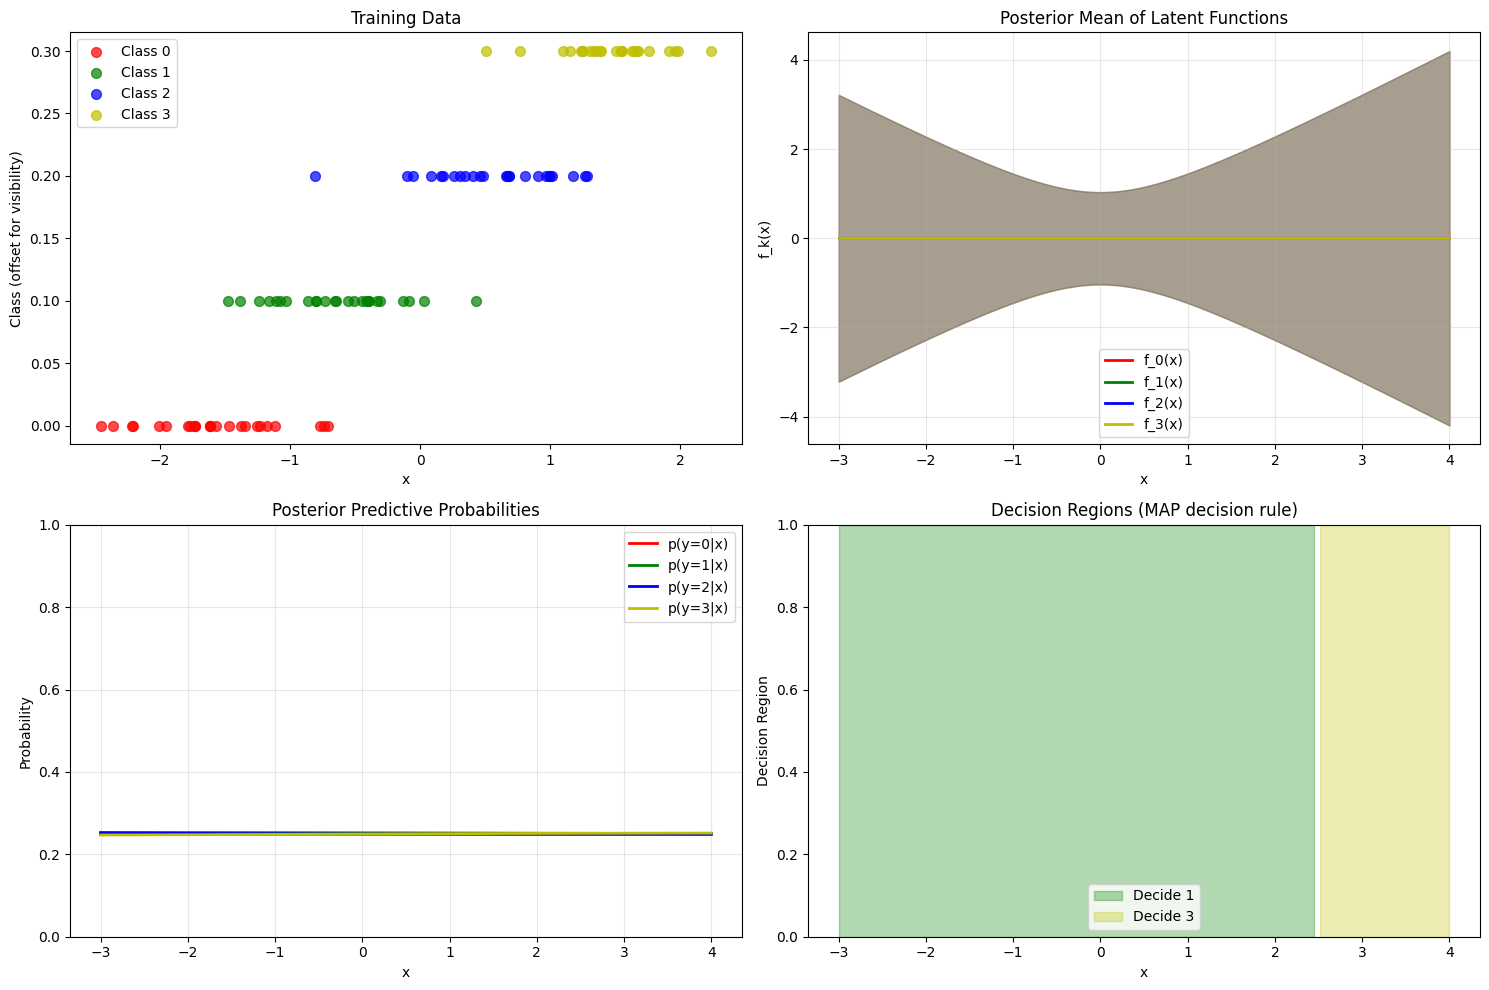


=== STEP 11: Confidence and Entropy ===


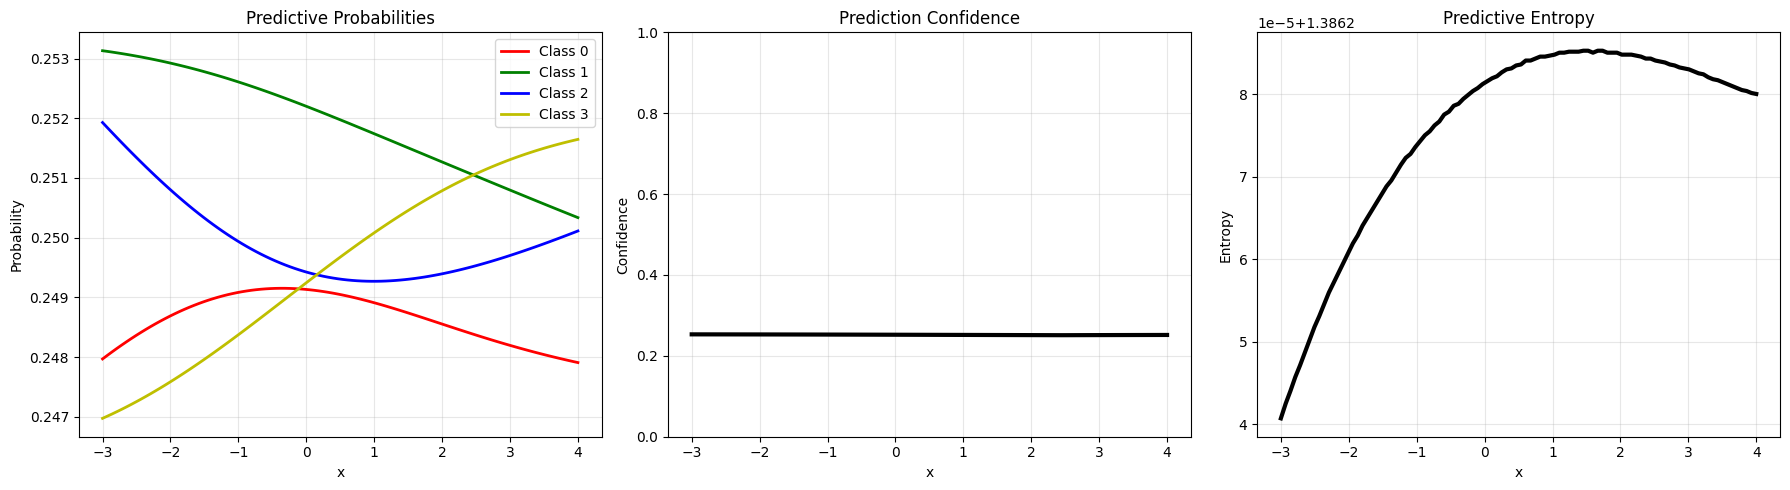


=== SUMMARY ===
MAP estimate found with 8 parameters
Posterior approximated as N(w_MAP, S)
Predictions made using 500 Monte Carlo samples
Decision regions clearly separate the classes
Confidence is high in regions with clear class dominance
Entropy is high at decision boundaries


In [1]:
import jax.numpy as jnp
import numpy as np
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from jax import grad, hessian
import jax.random as random

# =============================================================================
# STEP 1: Define Helper Functions
# =============================================================================
def log_npdf(x, m, v):
    """Log of normal probability density function"""
    return -0.5*(x-m)**2/v - 0.5*jnp.log(2*jnp.pi*v)

def to_onehot(y, num_classes):
    """Convert class labels to one-hot encoding"""
    return jnp.column_stack([1.0*(y==value) for value in jnp.arange(num_classes)])

def softmax(a):
    """Softmax function: p_i = exp(a_i) / Σ_j exp(a_j)"""
    exp_a = jnp.exp(a)
    return exp_a/jnp.sum(exp_a, 1)[:, None]

# =============================================================================
# STEP 2: Set Up Toy Problem 
# =============================================================================
print("=== STEP 2: Problem Setup - Toy Multiclass Classification ===")

# Generate toy data with 4 classes
np.random.seed(42)
num_classes = 4
N_per_class = 25
N = N_per_class * num_classes
D = 2  # Including intercept

# Generate data for each class
X_list = []
y_list = []
colors = ['r', 'g', 'b', 'y']

for k in range(num_classes):
    # Generate data points around different centers
    center = jnp.array([k - 1.5, 0])
    X_k = np.random.randn(N_per_class, 1) * 0.5 + center[0]
    X_list.append(X_k)
    y_list.append(k * jnp.ones(N_per_class, dtype=int))

# Combine all data
x = jnp.concatenate(X_list)
y = jnp.concatenate(y_list)

# Create design matrix with intercept
X = jnp.column_stack((jnp.ones(N), x))

print(f"Number of data points: {N}")
print(f"Number of classes: {num_classes}")
print(f"Number of features (including intercept): {D}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# One-hot encode the labels
y_onehot = to_onehot(y, num_classes)
print(f"y_onehot shape: {y_onehot.shape}")

# =============================================================================
# STEP 3: Bayesian Model Setup
# =============================================================================
print("\n=== STEP 3: Bayesian Model Setup ===")

# Prior hyperparameter
alpha = 1.0  # Precision of the prior
print(f"Prior precision α: {alpha}")

# Total number of parameters
num_params = num_classes * D
print(f"Total parameters: {num_params}")

# =============================================================================
# STEP 4: Implement Log Prior
# =============================================================================
print("\n=== STEP 4: Log Prior Implementation ===")

def log_prior(w_flat):
    """
    Log prior: p(W) = ∏_{i,j} N(w_ij | 0, 1/α)
    log p(W) = Σ_{i,j} log N(w_ij | 0, 1/α)
    """
    return jnp.sum(log_npdf(w_flat, 0, 1./alpha))

# Test log prior
w_test = jnp.zeros(num_params)
log_prior_val = log_prior(w_test)
print(f"Log prior at zero: {log_prior_val:.4f}")
print(f"Expected: {-num_params/2 * jnp.log(2*jnp.pi/alpha):.4f}")

# =============================================================================
# STEP 5: Implement Log Likelihood
# =============================================================================
print("\n=== STEP 5: Log Likelihood Implementation ===")

def log_likelihood(w_flat):
    """
    Log likelihood with categorical distribution and softmax:
    p(y | X, W) = ∏_n Categorical(y_n | softmax(X_n W^T))
    """
    # Reshape to weight matrix
    W = w_flat.reshape((num_classes, D))
    
    # Compute linear outputs: f_nk = X_n W_k^T
    logits = X @ W.T  # Shape: (N, K)
    
    # Apply softmax to get probabilities
    probs = softmax(logits)
    
    # Log likelihood: Σ_n log p(y_n | X_n, W)
    log_lik = jnp.sum(y_onehot * jnp.log(probs + 1e-10))
    
    return log_lik

# Test log likelihood
log_lik_val = log_likelihood(w_test)
print(f"Log likelihood at zero: {log_lik_val:.4f}")

# =============================================================================
# STEP 6: MAP Estimation
# =============================================================================
print("\n=== STEP 6: MAP Estimation ===")

def log_joint(w_flat):
    """Log posterior (up to constant): log p(W | y, X) ∝ log p(y | X, W) + log p(W)"""
    return log_prior(w_flat) + log_likelihood(w_flat)

def neg_log_joint(w_flat):
    """Negative log joint for minimization"""
    return -log_joint(w_flat)

# Initial guess
w_init = jnp.zeros(num_params)

# Find MAP estimate
print("Finding MAP estimate...")
result = minimize(neg_log_joint, w_init, method='BFGS')

if result.success:
    w_MAP = result.x
    print(f"Optimization successful!")
    print(f"Final negative log joint: {result.fun:.4f}")
else:
    print("Optimization failed!")
    
# Reshape MAP estimate
W_MAP = w_MAP.reshape((num_classes, D))
print(f"W_MAP shape: {W_MAP.shape}")
print(f"W_MAP:\n{W_MAP}")

# =============================================================================
# STEP 7: Laplace Approximation - Compute Hessian
# =============================================================================
print("\n=== STEP 7: Laplace Approximation ===")

# Compute Hessian at MAP
print("Computing Hessian...")
hess_func = hessian(neg_log_joint)
A = hess_func(w_MAP)
print(f"Hessian shape: {A.shape}")

# Posterior covariance (inverse of Hessian)
S = jnp.linalg.inv(A)
print(f"Posterior covariance shape: {S.shape}")

# Store Laplace approximation parameters
m_flat = w_MAP[:, None]  # Column vector

# =============================================================================
# STEP 8: Prediction at New Points
# =============================================================================
print("\n=== STEP 8: Predictions ===")

# Create test points
xstar = jnp.linspace(-3, 4, 100)
Xstar = jnp.column_stack((jnp.ones(len(xstar)), xstar))
P = len(xstar)

# Predict latent function means and variances
def predict_f(X_test):
    """Compute posterior distribution of f_k(x) = w_k^T x for each class"""
    # Get posterior mean for each class
    W_mean = m_flat.ravel().reshape((num_classes, D))
    
    # Extract covariance blocks for each class
    S_blocks = []
    for k in range(num_classes):
        idx_start = k * D
        idx_end = (k + 1) * D
        S_k = S[idx_start:idx_end, idx_start:idx_end]
        S_blocks.append(S_k)
    
    # Compute mean: μ_k(x) = W_k^T x
    mu_f = X_test @ W_mean.T  # Shape: (P, K)
    
    # Compute variance: σ²_k(x) = x^T S_k x
    var_f = jnp.zeros((len(X_test), num_classes))
    for k in range(num_classes):
        var_k = jnp.diag(X_test @ S_blocks[k] @ X_test.T)
        var_f = var_f.at[:, k].set(var_k)
    
    return mu_f, var_f

mu_f_star, var_f_star = predict_f(Xstar)
print(f"Predictive mean shape: {mu_f_star.shape}")
print(f"Predictive variance shape: {var_f_star.shape}")

# =============================================================================
# STEP 9: Monte Carlo Prediction of Class Probabilities
# =============================================================================
print("\n=== STEP 9: Monte Carlo Predictions ===")

def predict_y_monte_carlo(X_test, num_samples=500, seed=123):
    """
    Compute p(y* = k | y, x*) using Monte Carlo:
    p(y* = k | y, x*) ≈ (1/S) Σ_s p(y* = k | x*, W^(s))
    where W^(s) ~ N(W_MAP, S)
    """
    key = random.PRNGKey(seed)
    P_test = len(X_test)
    
    # Draw samples from posterior
    w_samples = random.multivariate_normal(key, m_flat.ravel(), S, shape=(num_samples,))
    
    # Initialize probability accumulator
    p_accumulator = jnp.zeros((P_test, num_classes))
    
    # For each sample
    for s in range(num_samples):
        # Reshape to weight matrix
        W_s = w_samples[s].reshape((num_classes, D))
        
        # Compute logits
        logits_s = X_test @ W_s.T
        
        # Apply softmax
        probs_s = softmax(logits_s)
        
        # Accumulate
        p_accumulator += probs_s
    
    # Average over samples
    p_avg = p_accumulator / num_samples
    
    return p_avg

# Compute predictive probabilities
phat = predict_y_monte_carlo(Xstar, num_samples=500)
print(f"Predictive probabilities shape: {phat.shape}")

# =============================================================================
# STEP 10: Visualization
# =============================================================================
print("\n=== STEP 10: Visualization ===")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Original data
ax = axes[0, 0]
for k in range(num_classes):
    mask = y == k
    ax.scatter(x[mask], jnp.zeros_like(x[mask]) + k*0.1, 
              c=colors[k], s=50, alpha=0.7, label=f'Class {k}')
ax.set_xlabel('x')
ax.set_ylabel('Class (offset for visibility)')
ax.set_title('Training Data')
ax.legend()

# Plot 2: Posterior mean of latent functions
ax = axes[0, 1]
for k in range(num_classes):
    ax.plot(xstar, mu_f_star[:, k], c=colors[k], linewidth=2, label=f'f_{k}(x)')
    ax.fill_between(xstar, 
                    mu_f_star[:, k] - 1.96*jnp.sqrt(var_f_star[:, k]),
                    mu_f_star[:, k] + 1.96*jnp.sqrt(var_f_star[:, k]),
                    color=colors[k], alpha=0.2)
ax.set_xlabel('x')
ax.set_ylabel('f_k(x)')
ax.set_title('Posterior Mean of Latent Functions')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Predictive probabilities
ax = axes[1, 0]
for k in range(num_classes):
    ax.plot(xstar, phat[:, k], c=colors[k], linewidth=2, label=f'p(y={k}|x)')
ax.set_xlabel('x')
ax.set_ylabel('Probability')
ax.set_title('Posterior Predictive Probabilities')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Decision regions
ax = axes[1, 1]
decisions = jnp.argmax(phat, axis=1)
for k in range(num_classes):
    decision_mask = decisions == k
    if jnp.any(decision_mask):
        ax.fill_between(xstar[decision_mask], 0, 1, 
                       color=colors[k], alpha=0.3, label=f'Decide {k}')
ax.set_xlabel('x')
ax.set_ylabel('Decision Region')
ax.set_title('Decision Regions (MAP decision rule)')
ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 11: Confidence and Entropy
# =============================================================================
print("\n=== STEP 11: Confidence and Entropy ===")

def confidence(p):
    """Maximum predicted probability for each sample"""
    return jnp.max(p, axis=1)

def entropy(p):
    """Predictive entropy: -Σ_k p_k log(p_k)"""
    return -jnp.sum(p * jnp.log(p + 1e-10), axis=1)

conf = confidence(phat)
ent = entropy(phat)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Predictive probabilities
ax = axes[0]
for k in range(num_classes):
    ax.plot(xstar, phat[:, k], c=colors[k], linewidth=2, label=f'Class {k}')
ax.set_xlabel('x')
ax.set_ylabel('Probability')
ax.set_title('Predictive Probabilities')
ax.legend()
ax.grid(True, alpha=0.3)

# Confidence
ax = axes[1]
ax.plot(xstar, conf, 'k-', linewidth=3)
ax.set_xlabel('x')
ax.set_ylabel('Confidence')
ax.set_title('Prediction Confidence')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

# Entropy
ax = axes[2]
ax.plot(xstar, ent, 'k-', linewidth=3)
ax.set_xlabel('x')
ax.set_ylabel('Entropy')
ax.set_title('Predictive Entropy')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY
# =============================================================================
print("\n=== SUMMARY ===")
print(f"MAP estimate found with {num_params} parameters")
print(f"Posterior approximated as N(w_MAP, S)")
print(f"Predictions made using {500} Monte Carlo samples")
print(f"Decision regions clearly separate the classes")
print(f"Confidence is high in regions with clear class dominance")
print(f"Entropy is high at decision boundaries")